* Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. 

* Time series forecasting is the use of a model to predict future values based on previously observed values.

* Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales

# Installing Libraries and dependencies

In [1]:
!pip install numpy
!pip install pandas
!pip install statsmodel
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Libraries and dependencies

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import itertools
import numpy as np
import pandas as pd
import statsmodels as sm

In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [5]:
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Loading Data

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

--- 

In [6]:
df = pd.read_excel("Superstore.xlsx")

In [7]:
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data.

In [8]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing

---

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [9]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']

In [10]:
furniture.drop(cols, axis=1, inplace=True)

In [11]:
furniture = furniture.sort_values('Order Date')

In [12]:
furniture.isnull().sum()

Unnamed: 0    0
Order Date    0
Sales         0
dtype: int64

In [13]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing with Time Series Data

--- 

In [14]:
furniture = furniture.set_index('Order Date')

In [15]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [16]:
y = furniture['Sales'].resample('MS').mean()

In [17]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Visualizing Furniture Sales Time Series Data

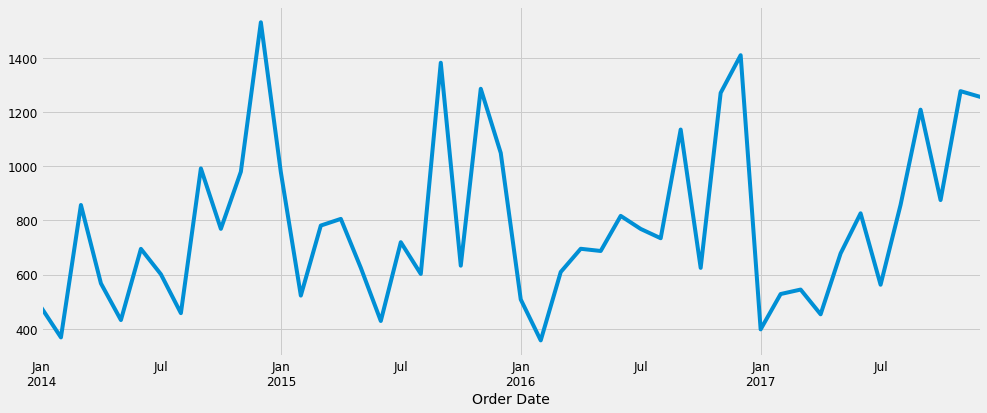

In [18]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data.

--- 

The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. 

---

There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called **time-series decomposition** that allows us to decompose our time series into three distinct components: 

1. trend
2. seasonality
3. noise.

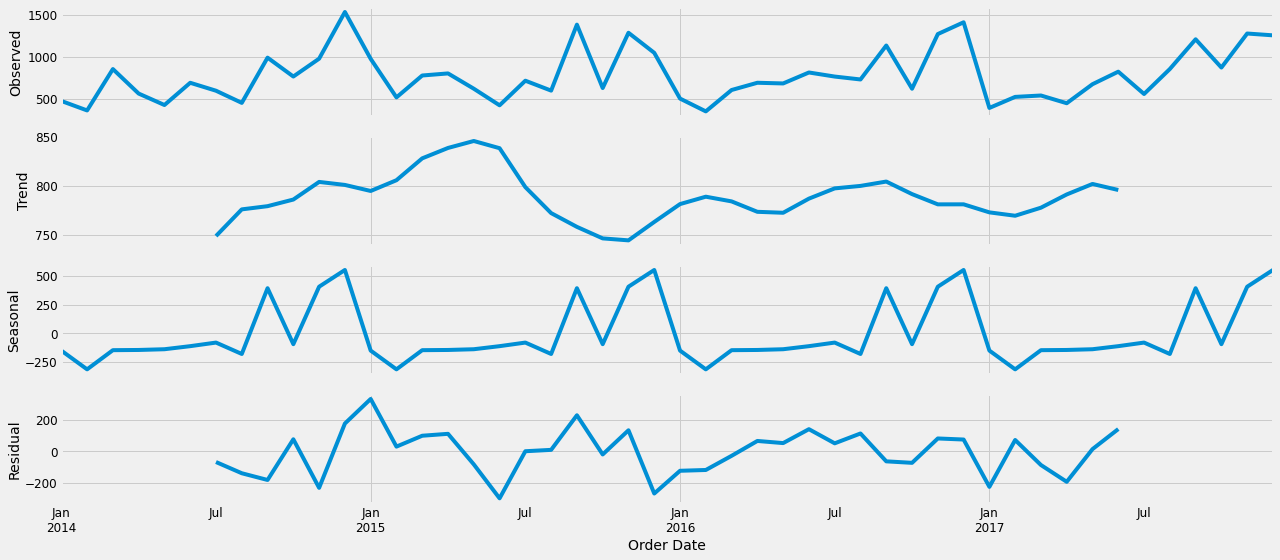

In [20]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

# Time series forecasting with ARIMA

--- 

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

* ARIMA models are denoted with the notation **ARIMA(p, d, q)**


* These three parameters account for seasonality, trend, and noise in data

In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. 

Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [24]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1463.1823222150024
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919809
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1406.9920952539087
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.00471991163414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758133
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3002.6496870317005
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809145
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.58966815106794
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2567.3176544576113
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468646
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1345.4886453430768
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567230478
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1354.6894854422305
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109212
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817093
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2494.8954906372455
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482604
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442633
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2641.501774419169
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75743684173756
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067713
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1506.5786892800977
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1489.3377636616958
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084553
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442185589
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1269143.6152908574
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958151055
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877059


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2507.93915874101
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002251161
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1142.9812781036426
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.34036587848124
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1339.180239137018
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454264
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835582
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2651.886880721484
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876104033
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546609177
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2506.3986565696473
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439538672


The above output suggests that **SARIMAX(1, 1, 1)x(1, 1, 0, 12)** yields the **lowest AIC value of 297.78.**

Therefore we should consider this to be **optimal option.**

# Fitting the ARIMA model

---

In [25]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [26]:
results = mod.fit()

In [27]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


**We should always run model diagnostics to investigate any unusual behavior.**

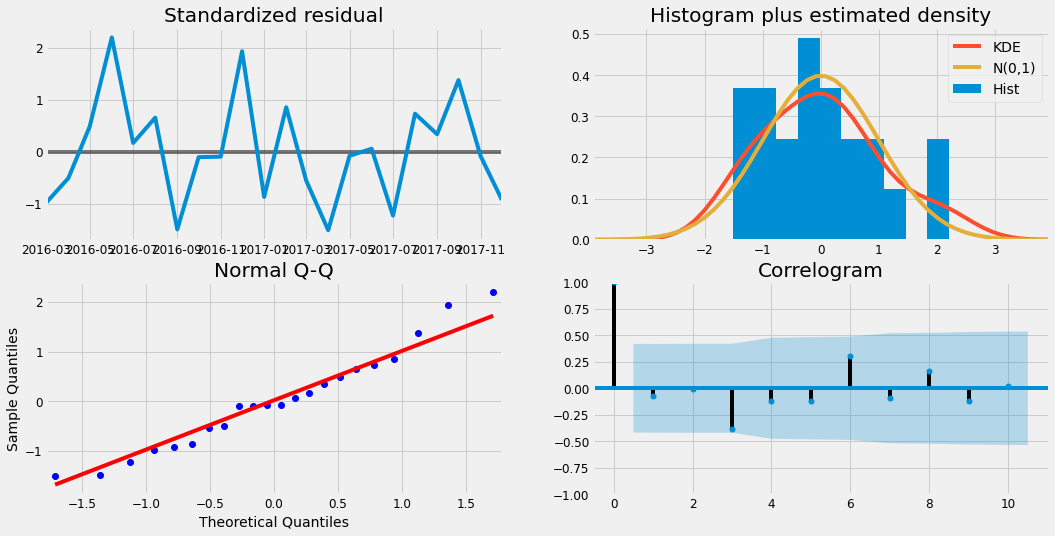

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

# Validating forecasts

---

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

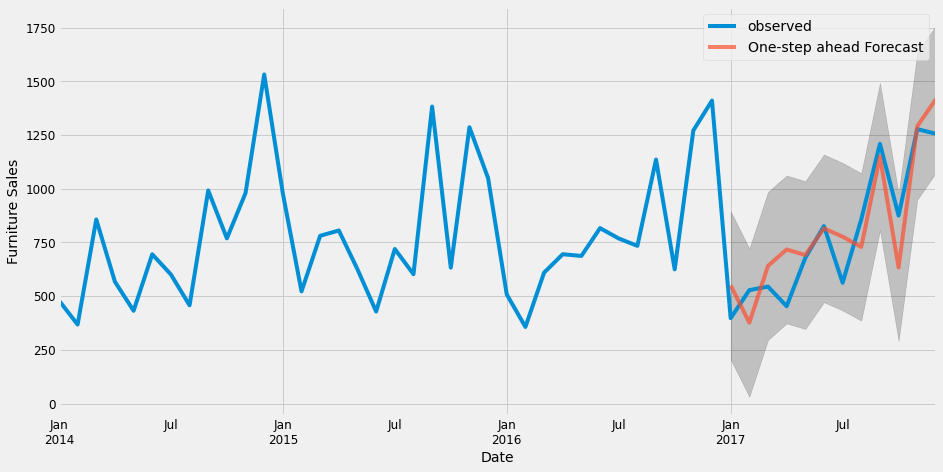

In [34]:
ax = y['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. 

Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [35]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [36]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


- In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. 

- The MSE is a measure of the quality of an estimator — it is always non-negative, 

- and the smaller the MSE, the closer we are to finding the line of best fit.

---

- Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. 

- Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

# Producing and visualizing forecasts

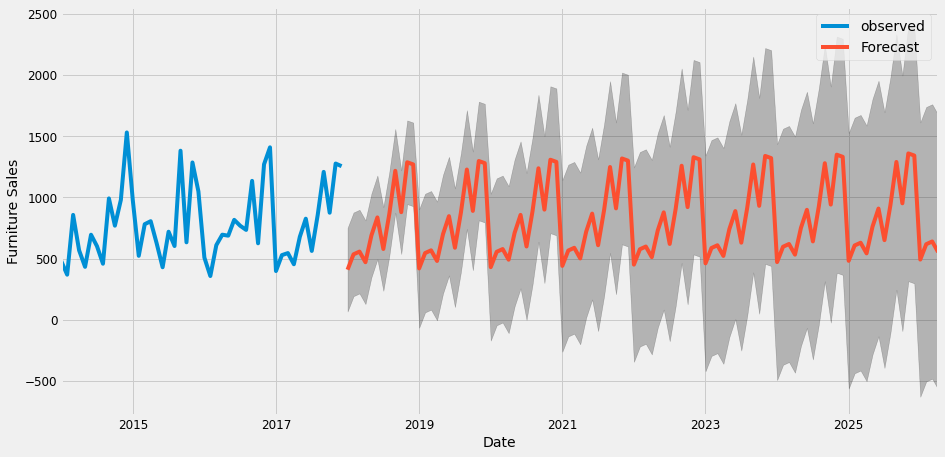

In [87]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

---

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier.

# Time Series of Furniture vs. Office Supplies

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [41]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 22), (6026, 22))

# Data Exploration

We are going to compare two categories’ sales in the same time period. 

This means combine two data frames into one and plot these two categories’ time series into one plot.

In [42]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']

In [43]:
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

In [44]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [45]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [46]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [47]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [48]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [49]:
store = furniture.merge(office, how='inner', on='Order Date')

In [50]:
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)

In [51]:
store.head()

,furniture_sales,office_sales
Order Date,,
2014-01-06,2573.820,685.340
2014-01-07,76.728,10.430
2014-01-10,51.940,2.890
2014-01-13,879.939,2027.116
2014-01-16,127.104,48.660


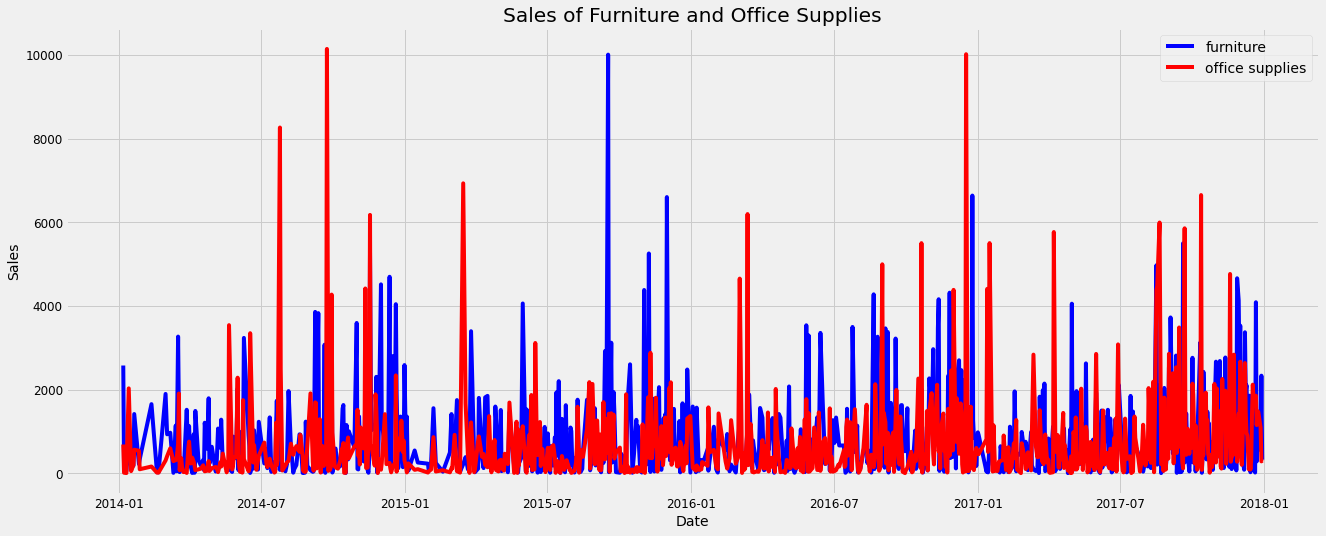

In [53]:
plt.figure(figsize=(20, 8))
store_ = store.reset_index()
plt.plot(store_['Order Date'], store_['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store_['Order Date'], store_['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales.

# Time Series Modeling with Prophet

---

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [56]:
from fbprophet import Prophet

In [60]:
furniture = furniture.reset_index()

In [61]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
office = office.reset_index()
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

In [65]:
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

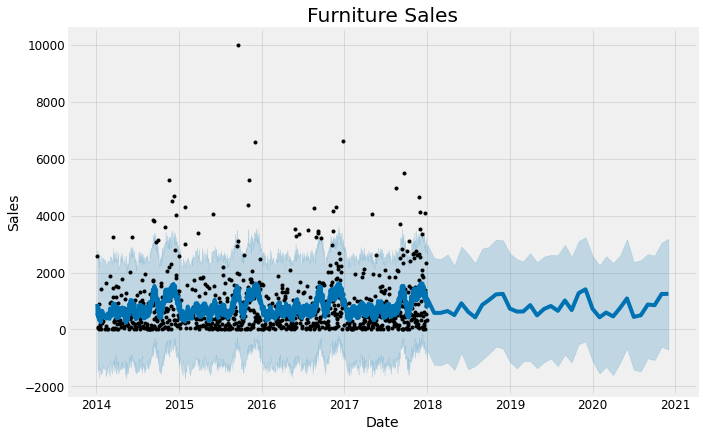

In [67]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

Text(0.5, 1.0, 'Office Supplies Sales')

<Figure size 1296x432 with 0 Axes>

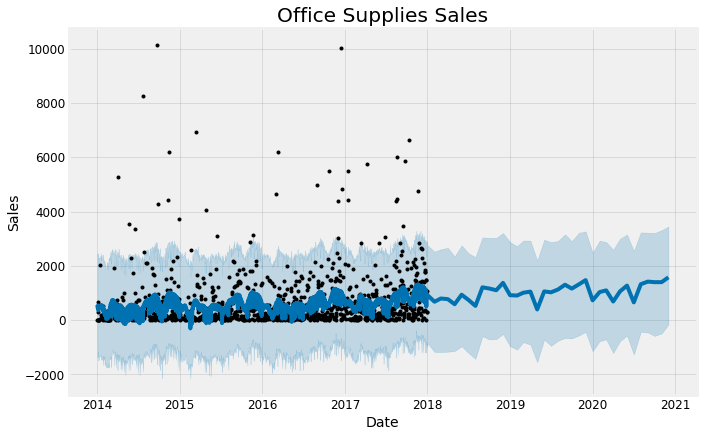

In [68]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales')

# Compare Forecasts

---

We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [69]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]

In [70]:
office_names = ['office_%s' % column for column in office_forecast.columns]

In [71]:
merge_furniture_forecast = furniture_forecast.copy()

In [72]:
merge_office_forecast = office_forecast.copy()

In [73]:
merge_furniture_forecast.columns = furniture_names

In [74]:
merge_office_forecast.columns = office_names

In [75]:
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

In [76]:
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)

In [77]:
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_weekly,...,office_weekly,office_weekly_lower,office_weekly_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-06,742.237559,-942.055016,2778.240370,742.237559,742.237559,153.488495,153.488495,153.488495,234.536543,...,136.189604,136.189604,136.189604,-86.918464,-86.918464,-86.918464,0.0,0.0,0.0,541.330740
1,2014-01-07,742.266801,-1467.884437,2428.649726,742.266801,742.266801,-250.186118,-250.186118,-250.186118,-140.421258,...,-33.114884,-33.114884,-33.114884,-95.044562,-95.044562,-95.044562,0.0,0.0,0.0,363.900745
2,2014-01-10,742.354527,-1377.099219,2667.832684,742.354527,742.354527,-96.887180,-96.887180,-96.887180,93.254252,...,120.861332,120.861332,120.861332,-106.711128,-106.711128,-106.711128,0.0,0.0,0.0,506.212169
3,2014-01-13,742.442254,-1151.809290,2693.299534,742.442254,742.442254,-23.776613,-23.776613,-23.776613,234.536543,...,136.189604,136.189604,136.189604,-102.196368,-102.196368,-102.196368,0.0,0.0,0.0,526.056975
4,2014-01-16,742.529981,-1459.049118,2397.716053,742.529981,742.529981,-256.638535,-256.638535,-256.638535,53.070271,...,59.590327,59.590327,59.590327,-88.360852,-88.360852,-88.360852,0.0,0.0,0.0,463.294988


# Trend and Forecast Visualization

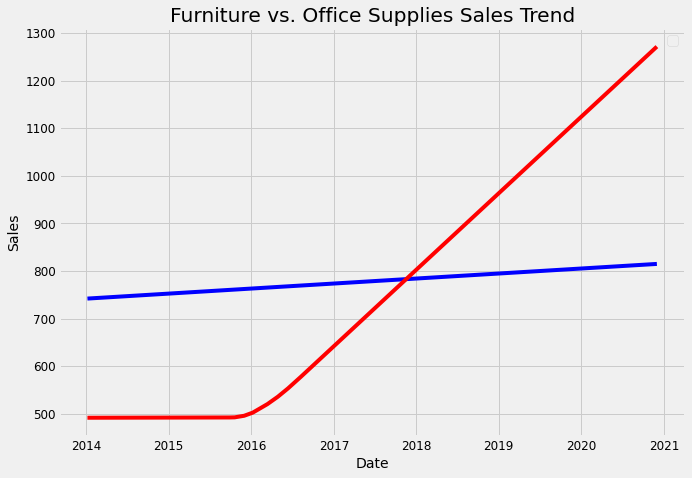

In [78]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

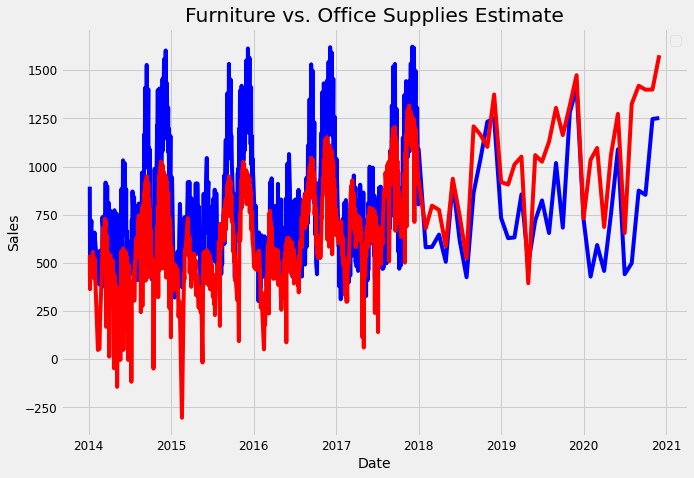

In [79]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Trends and Patterns

---

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

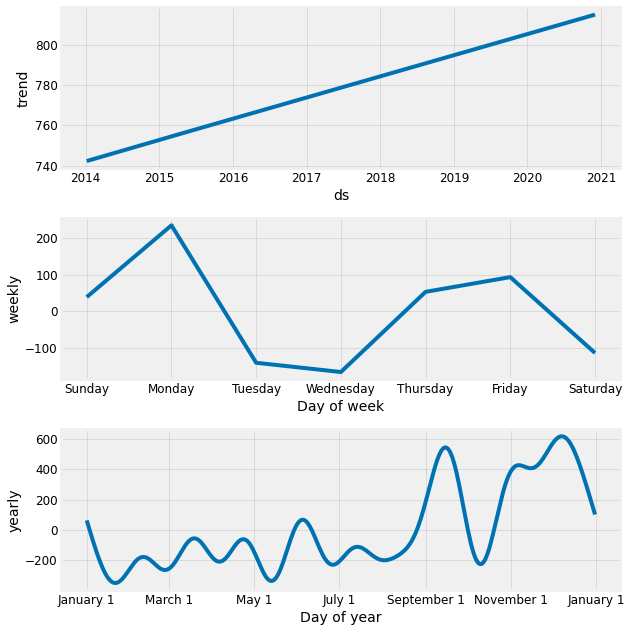

In [80]:
furniture_model.plot_components(furniture_forecast);

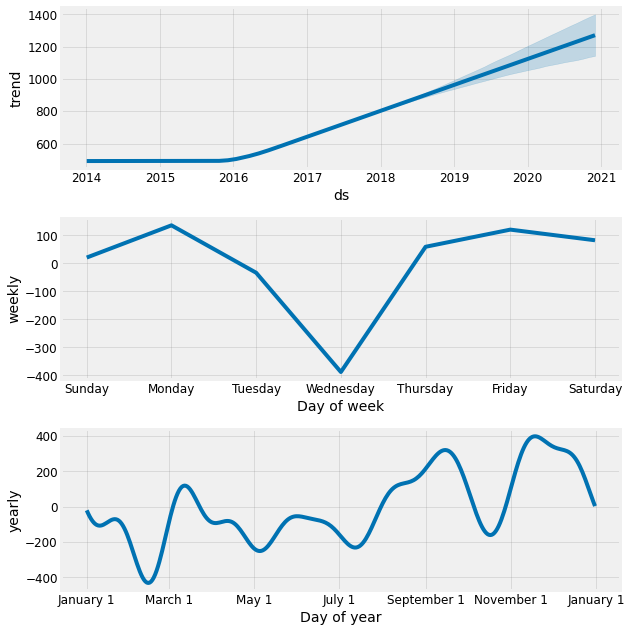

In [81]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.

# Source:

---

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b